# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Data Base

In [2]:
%%capture

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *

# Choose indicator by uncommenting one of the following lines
#indicator = 'calcium'
indicator = 'glutamate'

database.connect_dj(indicator=indicator)

# Data

In [3]:
roi_pos_tab = database.get_roi_pos_tab(stim_restriction=dict(stim_name='gChirp'))
location_tab = database.get_location_tab()

gchirp_tab = database.get_gchirp_tab(quality_filter=True)
lchirp_tab = database.get_lchirp_tab(quality_filter=True)
sinespot_tab = database.get_sinespot_tab(quality_filter=True)

clustering_tab = database.get_clustering_tab(quality_filter=True)

rf_tab = database.get_rf_tab(quality_filter=True)

cell_tab = database.get_experiment_tab(quality_filter=True)

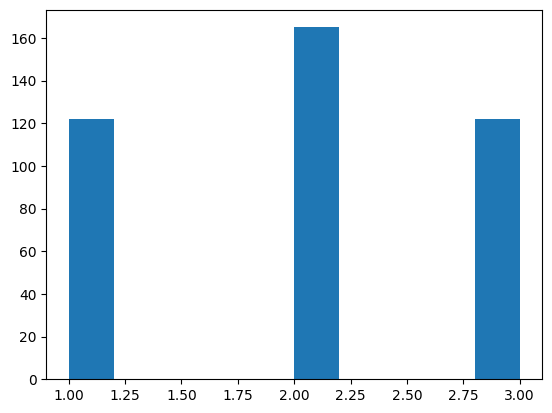

In [4]:
plt.hist((clustering_tab & ((Roi().proj() & (Averages & dict(stim_name='gChirp'))) - (
            Roi().proj() & (Averages & dict(stim_name='sinespot'))))).fetch('cluster_idx'));

In [5]:
# Make sure everything is populated
assert len(roi_pos_tab.proj()) > 0
assert len(location_tab.proj()) > 0
assert len(gchirp_tab.proj()) > 0
assert len(lchirp_tab.proj()) > 0
assert len(sinespot_tab.proj()) > 0
assert len(clustering_tab.proj()) > 0
assert len(rf_tab.proj()) > 0

In [6]:
# Make sure clustering tables have the same length
assert len(roi_pos_tab.proj()) == len(gchirp_tab.proj())
assert len(roi_pos_tab.proj()) == len(lchirp_tab.proj())
assert len(roi_pos_tab.proj()) == len(clustering_tab.proj()), f"{len(roi_pos_tab.proj())} {len(clustering_tab.proj())}"

# Extract info for text

In [7]:
print(indicator)
print((database.FeaturesParams() & clustering_tab).fetch1())
print((database.ClusteringParameters() & clustering_tab).fetch1())

glutamate
{'features_id': 1, 'kind': 'none', 'params_dict': {'roi_filter_restr': {'quality_params_id': 1}}, 'norm_trace': 0, 'stim_names': 'gChirp_lChirp', 'ncomps': ''}
{'clustering_id': 1, 'kind': 'hierarchical_ward', 'params_dict': {'distance_threshold': 110}, 'min_count': 0}


In [8]:
for i in np.unique(clustering_tab.fetch('cluster_idx')):
    print(np.min((roi_pos_tab & (clustering_tab & dict(cluster_idx=i))).fetch('d_dist_to_soma')))

22.5877
13.909
25.3417


# Plot

In [9]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [10]:
FIGURE_FOLDER = './figures/'

In [11]:
u_cluster_idxs = np.unique(clustering_tab.fetch('cluster_idx'))
u_cluster_idxs = u_cluster_idxs[u_cluster_idxs > 0]

rf_cdia_um_rng = plota.data_to_range(rf_tab.fetch('rf_cdia_um'))
surround_index_rng = plota.data_to_range(rf_tab.fetch('surround_index'))
d_dist_to_soma_rng = plota.data_to_range(roi_pos_tab.fetch('d_dist_to_soma'))

In [12]:
if indicator == 'calcium':
    colors = sns.color_palette("cool", n_colors=u_cluster_idxs.size + 2).as_hex()[2:]
else:
    colors = sns.color_palette("plasma_r", n_colors=u_cluster_idxs.size + 2).as_hex()[2:]

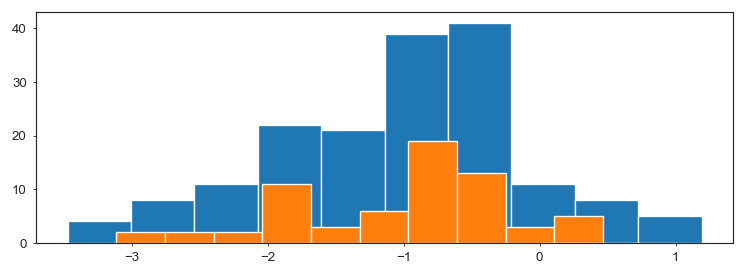

In [13]:
for i in [1, 2, 3]:
    plt.hist((sinespot_tab & (clustering_tab & dict(cluster_idx=i))).fetch('sinespot_surround_index'), label=i)

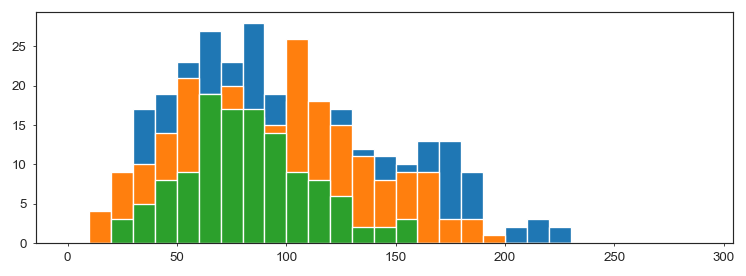

In [14]:
distances = []
for i in [1, 2, 3]:
    distances.append((roi_pos_tab & (clustering_tab & dict(cluster_idx=i))).fetch('d_dist_to_soma'))

for i in [1, 2, 3]:
    plt.hist(distances[i - 1], label=i, bins=np.arange(0, 300, 10))

## Text

In [15]:
print(f"{np.sum(distances[-1] < 25) / np.sum(np.concatenate(distances) < 25):.0%}")

0%


In [16]:
for i in [1, 2, 3]:
    print(f"{i}: {np.sum(distances[i - 1] < 25) / distances[i - 1].size:.0%}")

1: 0%
2: 3%
3: 0%


In [17]:
for i in [1, 2, 3]:
    print(f"{i}: {len(clustering_tab & f'cluster_idx={i}')}")

1: 292
2: 231
3: 122


In [18]:
for i in [1, 2, 3]:
    print(f"{i}: {np.sum(distances[i - 1] < 75) / distances[i - 1].size:.0%}")

1: 36%
2: 38%
3: 44%


In [19]:
for group in ['n', 'd', 't']:
    print(group)
    cs, ccs = np.unique((clustering_tab & (location_tab & dict(group=group))).fetch('cluster_idx'), return_counts=True)
    ccs = ccs / np.sum(ccs)
    for c, cc in zip(cs, ccs):
        print(f"C{c}: {cc:.0%}; ", end='')
    print()

n
C1: 66%; C2: 34%; 
d

t
C1: 29%; C2: 37%; C3: 34%; 


## Cluster responses

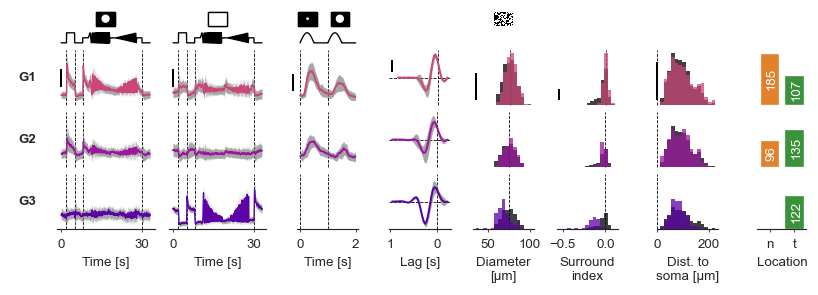

In [20]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

DEBUG = False

fig, axs = plt.subplots(
    u_cluster_idxs.size + 2, 9, figsize=(7, u_cluster_idxs.size * 0.5 + 1) if not DEBUG else (12, 6),
    gridspec_kw=dict(width_ratios=(0.5, 1.6, 1.6, 1., 1., 1., 1., 1., 0.8),
                     height_ratios=(0.25, 0.2,) + (1,) * u_cluster_idxs.size), squeeze=False)

ax_col_left = axs[2:, 0]
ax_row_spatial = axs[0, :]
ax_row_top = axs[1, :]
axs_data = axs[2:, 1:]

# Plot stimuli
plota.plot_spot_spatial(ax_row_spatial[1], s_list=[300], w=800, h=600)
plota.plot_chirp(ax=ax_row_top[1], c='k', lw=0.8, tmax=33, clip_on=False)

plota.plot_spot_spatial(ax_row_spatial[2], s_list=[1000], w=800, h=600)
plota.plot_chirp(ax=ax_row_top[2], c='k', lw=0.8, tmax=33, clip_on=False)

plota.plot_spot_spatial(ax_row_spatial[3], s_list=[60, 300], w=800, h=600, space=600)
plota.plot_sinespot(ax=ax_row_top[3], c='k', lw=0.8, clip_on=False)

plota.plot_noise(ax=ax_row_spatial[5])

# Row titles
for ax, cidx in zip(ax_col_left, u_cluster_idxs):
    ax.text(0.5, 0.5, f"{indicator[0].upper()}{cidx}", ha='center', va='center',
            weight="bold")
    ax.set(xlim=(0, 1), ylim=(0, 1))
    ax.axis('off')

# Cluster data
for i, (ax_row, cidx) in enumerate(zip(axs_data, u_cluster_idxs)):
    cidx_tab = (clustering_tab & dict(cluster_idx=cidx))

    c = colors[i]

    # Traces
    plota.plot_traces(ax_row[0], lchirp_tab & cidx_tab, (2, 5, 8, 30), color=c, lw=0.8)
    plota.plot_traces(ax_row[1], gchirp_tab & cidx_tab, (2, 5, 8, 30), color=c, lw=0.8)
    plota.plot_traces(ax_row[2], sinespot_tab & cidx_tab, (0, 1), xlim=(0, 2), color=c, lw=1.2, dt=-0.25)

    # RF data
    ax = ax_row[3]
    tab = rf_tab & cidx_tab
    try:
        times = [-t for t in tab.fetch('rf_time')]
    except dj.DataJointError:
        model_dicts = tab.fetch('model_dict')

        if "rf_time" in model_dicts[0]:
            times = [model_dict['rf_time'] for model_dict in model_dicts]
        else:
            keys = tab.fetch('KEY')
            key = keys[0]
            dt, trf, model_dict = (tab & key).fetch1('dt', 'trf', 'model_dict')
            n_t = trf.shape[0]
            shift = model_dict['shift']
            times = -(-np.arange(n_t) * dt - shift['stimulus'] * dt)[::-1]
            times = [times] * len(keys)

    if len(tab) > 0:
        ax.invert_xaxis()
        plota.plot_cluster_mean(ax, times=times, traces=tab.fetch('trf'), color=c)
        plota.lines(ax, ts=(0,), orientation='v')
        plota.lines(ax, ts=(0,), orientation='h')
    ax.set_xlabel('Lag [s]')

    ax = ax_row[4]
    plota.plot_hists(ax, (rf_tab & cidx_tab).fetch('rf_cdia_um'), rf_tab.fetch('rf_cdia_um'), binrange=rf_cdia_um_rng,
                     c=c)
    plota.lines(ax, ts=(100,) if indicator == 'calcium' else (75,), orientation='v')
    ax.set_xlabel('Diameter\n[µm]')

    ax = ax_row[5]
    plota.plot_hists(ax, (rf_tab & cidx_tab).fetch('surround_index'), rf_tab.fetch('surround_index'),
                     binrange=surround_index_rng, c=c)
    plota.lines(ax, ts=(0,), orientation='v')
    ax.set_xlabel('Surround\nindex')
    if indicator == 'calcium':
        ax.set_xticks([-0.25, 0, 0.25])
        ax.set_xticklabels(["-0.25", "0", "0.25"])

    # Distance to soma
    ax = ax_row[6]
    plota.plot_hists(ax, (roi_pos_tab & cidx_tab).fetch('d_dist_to_soma'), roi_pos_tab.fetch('d_dist_to_soma'),
                     binrange=d_dist_to_soma_rng, c=c)
    plota.lines(ax, ts=(0,), orientation='v')
    ax.set(xlabel='Dist. to\nsoma [µm]', xlim=(0, None))

    # Location
    ax = ax_row[7]
    locs = (roi_pos_tab * location_tab * cidx_tab).fetch('group')
    plota.annotated_countplot(ax, counts=locs, order=plota.get_order(indicator), palette=plota.get_palette(indicator))
    ax.set(xlabel='Location')

# Vertical scale bars
plota.plot_scale_bar(axs_data[0, 0], x0=0, y0=0.5 if indicator == 'glutamate' else -0.5, size=2, pad=-10, text='',
                     orientation='v')
plota.plot_scale_bar(axs_data[0, 1], x0=0, y0=0.5 if indicator == 'glutamate' else -0.5, size=2, pad=-10, text='',
                     orientation='v')
plota.plot_scale_bar(axs_data[0, 2], x0=-0.25, y0=0 if indicator == 'glutamate' else -0.5, size=2, pad=-10, text='',
                     orientation='v')
plota.plot_scale_bar(axs_data[0, 3], x0=1.1, y0=0.25, size=0.5, pad=-10, text='', orientation='v')

for i in [4, 5, 6]:
    ax = axs_data[0, i]
    plota.plot_scale_bar(ax, x0=ax.get_xlim()[0], y0=0.1 * ax.get_ylim()[1], size=30, pad=-10, text='', orientation='v')

# Layout
sns.despine(bottom=True, top=True, left=True, right=True)

for ax in axs_data.flat:
    ax.set_facecolor('none')

for ax in ax_row_spatial:
    ax.axis('off')

for ax in ax_row_top:
    for name, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axs_data[-1, :].flat:
    ax.spines['bottom'].set_visible(True)

for ax in axs_data[:-1, :-1].flat:
    ax.set(xticks=[], xlabel=None)

if not DEBUG:
    for ax in axs_data.flat:
        ax.set(yticks=[], ylabel=None)

for ax in axs_data[:-1, -1].flat:
    ax.set(xticks=[], xlabel=None)

for ax in axs_data[-1, :2]:
    ax.set(xticks=(0, 30))

## Data limits
plota.make_share_xlims(axs[1:, 1:3])  # Include stimulus
plota.make_share_xlims(axs[1:, 3])  # Include stimulus
plota.make_share_ylims(axs[2:, 1:4])

for ax_col in axs.T[-5:]:
    plota.make_share_ylims(ax_col[2:])

## Tight layout
plt.tight_layout(h_pad=0.5, w_pad=0.6, rect=(0, 0, 0.94, 1))
fig.align_labels()

# Fine-tuning
plota.move_box(ax_row_spatial[3], dx=-0.005)
plota.move_box(axs[:, 1], dx=-0.01)
plota.move_box(axs[:, 2], dx=-0.02)
plota.move_box(axs[:, 3], dx=-0.01)

plota.move_box(axs[:, -1], dx=0.04)
plota.move_box(axs[:, -2], dx=0.02)

# Save
fig.savefig(os.path.join(FIGURE_FOLDER, f'response_clusters_{indicator}.pdf'))

## Cluster distribution per cell

In [21]:
cell_keys = cell_tab.fetch(as_dict=True, order_by='cell_tag')

In [22]:
cell_cluster_dists = [(clustering_tab & cell_key).fetch('cluster_idx') for cell_key in cell_keys]

In [23]:
cell_dicts = []
for cell_key in cell_keys:
    cluster_idx = (clustering_tab & cell_key).fetch('cluster_idx')
    cell_dict = dict(cell_tag=(cell_tab & cell_key).fetch1('cell_tag'), date=cell_key['date'],
                     exp_num=cell_key['exp_num'])
    cell_dict['group'] = cell_dict['cell_tag'][:-1]
    cell_dict['n_rois'] = cluster_idx.size

    for cidx in u_cluster_idxs:
        cell_dict[f'C{cidx}'] = np.sum(cluster_idx == cidx)

    cell_dicts.append(cell_dict)

df_cells = pd.DataFrame(cell_dicts).sort_values(['cell_tag', 'n_rois'])
df_cells

,cell_tag,date,exp_num,group,n_rois,C1,C2,C3
0,n1,2020-11-03,2,n,37,27,10,0
1,n2,2020-11-10,2,n,65,64,1,0
2,n3,2020-11-11,1,n,61,35,26,0
3,n4,2020-11-27,1,n,49,30,19,0
4,n5,2020-11-27,2,n,69,29,40,0
5,t1,2020-11-04,5,t,64,27,37,0
6,t2,2020-11-04,6,t,49,30,19,0
7,t3,2020-11-03,1,t,67,50,17,0
8,t4,2020-11-04,1,t,62,0,62,0
9,t5,2020-11-10,3,t,30,0,0,30


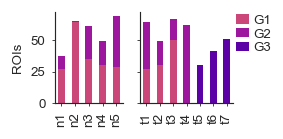

In [24]:
group_order = plota.get_order(indicator=indicator)
group_names, group_counts = np.unique(df_cells.group, return_counts=True)
assert set(group_names) == set(group_order)
group_counts_ordered = np.array([group_counts[np.argmax(group_names == group)] for group in group_order])

fig, axs = plt.subplots(1, len(group_order), figsize=(len(group_names) * 0.7 + 1, 1.2), sharey='all',
                        gridspec_kw=dict(width_ratios=group_counts_ordered + 0.5), sharex=False)
sns.despine()

cluster_prefix = 'C' if indicator.lower().startswith('ca') else 'G'

for ax, group in zip(axs, group_order):
    bars = df_cells[df_cells.group == group].plot(ax=ax, kind='bar', x="cell_tag",
                                                  y=[f'C{cidx}' for cidx in u_cluster_idxs], stacked=True, color=colors,
                                                  ec='none', xlabel='')

handles, labels = axs[-1].get_legend().legend_handles, axs[-1].get_legend().get_texts()
labels = [l.get_text().replace('C', cluster_prefix) for l in labels]
axs[-1].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), handlelength=1)

for ax in axs[:-1]:
    ax.get_legend().remove()

axs[0].set_ylabel(r'ROIs')

plt.tight_layout(w_pad=1)

fig.savefig(os.path.join(FIGURE_FOLDER, f'response_clusters_per_cell_{indicator}.pdf'), bbox_inches='tight')

## Plot dendrogram

In [26]:
from djimaging.user.alpha.schemas.alpha_schema import Clustering, FeaturesParams

In [27]:
features_id = np.unique(clustering_tab.fetch("features_id"))[0]
clustering_id = np.unique(clustering_tab.fetch("clustering_id"))[0]
stim_names = (FeaturesParams & dict(features_id=features_id)).fetch1('stim_names').split('_')

In [28]:
stim_names

['gChirp', 'lChirp']

In [29]:
from djimaging.tables.clustering.clustering import cluster_features, remove_clusters, sort_clusters

key = dict(features_id=features_id, clustering_id=clustering_id)

kind, params_dict, min_count = (Clustering.params_table & key).fetch1('kind', 'params_dict', 'min_count')
features = (Clustering.features_table & key).fetch1('features')
decomp_kind = (Clustering.features_table.params_table & key).fetch1('kind')
traces = (Clustering.features_table() & key).fetch1('traces')
db_cluster_index = clustering_tab.fetch('cluster_idx')

model, cluster_idxs = cluster_features(np.hstack(features), kind, params_dict)
cluster_idxs = remove_clusters(cluster_idxs=cluster_idxs, min_count=min_count, invalid_value=-1)
cluster_idxs = sort_clusters(traces=np.hstack(traces), cluster_idxs=cluster_idxs, invalid_value=-1)

assert np.all(db_cluster_index == cluster_idxs)

In [30]:
len(db_cluster_index)

645

In [31]:
len(features[0])

645

In [32]:
len(cluster_idxs)

645

In [33]:
len(traces[0])

645

[1 2 3] [292 231 122]
[1 2 3] [292 231 122]


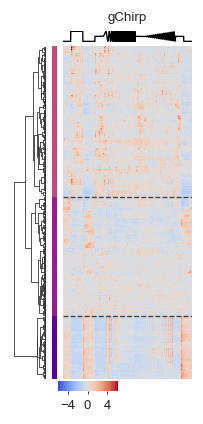

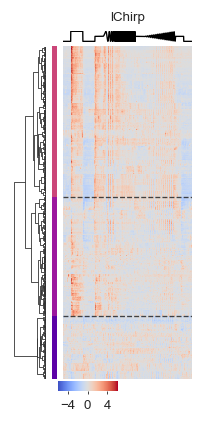

In [34]:
cl_maps = plota.plot_dendrogram(
    model, features=features, cluster_idxs=cluster_idxs.astype(int), colors=colors,
    file_path=os.path.join(FIGURE_FOLDER, f'dendrogram_{indicator}'), suffixes=stim_names,
    invert_y_axis=indicator == 'glutamate'
)